In [1]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2

import scipy.signal as signal
from obspy.signal import filter as obsfilt

In [2]:
import glob
file_list = glob.glob("/home/ldoyle/notebooks/rad_10_smooth_data/*")

In [16]:
len(file_list)

28

In [23]:
# n = 1.4682
# L = 51.04762
# working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*np.load(file_list[-3])[:,::10]
# #     "gaussian_smoothed_2021-11-01T231214Z_channels_7500_12500South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231114Z.npy") #full_dat[:,-48000:-24000]
# working_dat = working_dat.T *10**6#/(np.std(working_dat))
# mean_remove = (working_dat - np.mean(working_dat,axis=0)).T
# working_dat = mean_remove.reshape(mean_remove.shape[0],mean_remove.shape[1],1)

In [17]:
n = 1.4682
L = 51.04762

b=0
for q in np.arange(23,28):
    if b==0:
        working_dat = np.load(file_list[q])
        b=1
    else:
        working_dat = np.hstack((working_dat, np.load(file_list[q])))
        
working_dat = ((2*np.pi)/2**16)*((1550.12 * 1e-9)/(0.78 * 4 * np.pi * n * L))*working_dat[:,::10]

working_dat = working_dat.T *10**6#/(np.std(working_dat))
mean_remove = (working_dat - np.mean(working_dat,axis=0)).T
working_dat = mean_remove.reshape(mean_remove.shape[0],mean_remove.shape[1],1)

In [18]:
dx=2.0419047
dt=10./200.
ut = ps.FiniteDifference(d=1, axis=1,order=4,is_uniform=True,
                         drop_endpoints=False)._differentiate(working_dat, dt)
ux = ps.FiniteDifference(d=1, axis=0,order=4,is_uniform=True,
                         drop_endpoints=False)._differentiate(working_dat, dx)
uxx = ps.FiniteDifference(d=2, axis=0,order=4,is_uniform=True,
                          drop_endpoints=False)._differentiate(working_dat, dx)
uxxx = ps.FiniteDifference(d=3, axis=0,order=4,is_uniform=True,
                           drop_endpoints=False)._differentiate(working_dat, dx)
uxxxx = ps.FiniteDifference(d=4, axis=0,
                            drop_endpoints=False)._differentiate(working_dat, dx)


In [26]:
np.mean(np.abs(working_dat))

0.36301504306447613

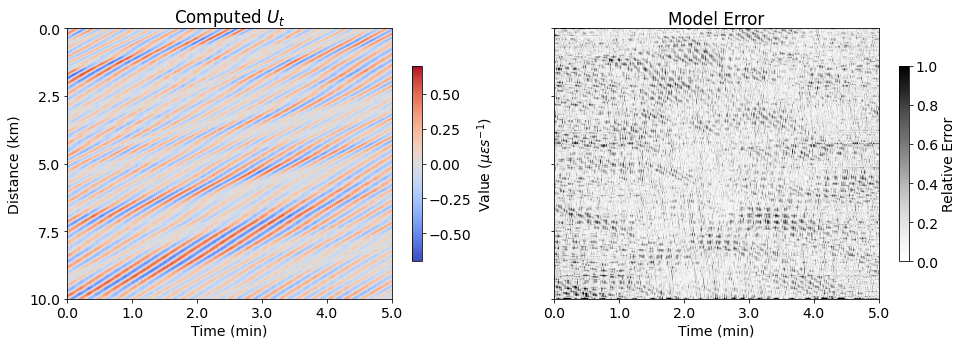

In [70]:
plt.rcParams.update({'font.size': 14})
# output = (26.067*ux[:,:,0]) + (5152.704* uxxx[:,:,0]) + (72.901* working_dat[:,:,0] * uxxxx[:,:,0])
# output = (26.067*ux[:,:,0]) + (5156.326* uxxx[:,:,0]) + (39.543* working_dat[:,:,0] * uxxxx[:,:,0]) +(34.255* working_dat[:,:,0] * uxx[:,:,0])
output1 = 25.441*ux[:,:,0] + 5312.788 *uxxx[:,:,0] #26.053*ux[:,:,0]+ (5152.704* uxxx[:,:,0])
output2 = (25.444*ux[:,:,0]) + (5288.368* uxxx[:,:,0]) + (120.028* working_dat[:,:,0] * uxxxx[:,:,0])-(2.885 *uxx[:,:,0])

fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (16, 6),sharey=True)
# fig.suptitle('$u_t$ Approximations',fontsize=18,y=1.02)
fig.patch.set_facecolor('white') # Good for dark themed notebooks
im = ax[0].imshow((ut[:,:,0]),vmin=-0.7, vmax=0.7,
#                extent = [0,600,  0,500],
               cmap = 'coolwarm')

ax[0].set_xlabel("Time (min)",size=14)
ax[0].set_xticks(np.linspace(0,6000,6),np.linspace(0,5,6))
ax[0].set_ylabel("Distance (km)",size=14, labelpad = 8)#, fontsize = 16)
ax[0].set_title('Computed $U_t$', pad=0.05)

im2 = ax[1].imshow(np.abs(ut[:,:,0]-output2)/0.14522991720299366,vmin=0., vmax=1.,
#                extent = [0,600,  0,500],
               cmap = 'Greys')
ax[1].set_xticks(np.linspace(0,6000,6),np.linspace(0,5,6))
ax[1].set_title('Model Error', pad=0.04)
ax[1].set_xlabel("Time (min)",size=14)

ax[0].set_yticks(np.linspace(0, 5000, 5),
           (2/1000)*np.linspace(0, 5000, 5))
# ax[1].set_yticks(None)
# im = ax[2].imshow((ux[:,:,0]),vmin=-0.7, vmax=0.7,
# #                extent = [0,600,  0,500],
#                cmap = 'coolwarm')
# ax[2].set_title('Linear Model', pad=0.04)

#file.split('.')[0]
fig.colorbar(im, ax = ax[0], pad = 0.05,shrink=0.6, label="Value ($\mu \epsilon s^{-1}$)")
fig.colorbar(im2, ax = ax[1], pad = 0.05,shrink=0.6, label="Relative Error")

plt.show()

In [47]:
# output2 = (26.059*ux[:,:,0]) + (5157.999* uxxx[:,:,0]) + (63.377* working_dat[:,:,0] * uxxxx[:,:,0])
output2 = (25.444*ux[:,:,0]) + (5288.368* uxxx[:,:,0]) + (120.028* working_dat[:,:,0] * uxxxx[:,:,0])-(2.885 *uxx[:,:,0])
# 25.444 x0_1 + -2.885 x0_11  + 5288.368 x0_111 + 120.028 x0x0_1111
kdv = (6*working_dat[:,:,0]*ux[:,:,0])-uxxx[:,:,0]
print(np.mean(np.abs(ut)))
print(np.mean(np.square(ut[:,:,0]-output)))
print(np.mean(np.square(ut[:,:,0]-output1)))
print(np.mean(np.square(ut[:,:,0]-output2)))
# print(np.mean(np.square(ut[:,:,0]-kdv)))

# print(np.mean(np.abs(output1-ut[:,:,0])))

0.14522991720299366
0.0017483880212586153
0.0017325144379352622
0.0017324811790830259


In [61]:
np.mean(np.abs(ut[:,:,0]-output2)/np.abs(ut[:,:,0]))

2.2444871138808975

In [33]:
np.amax(np.abs(63.377* working_dat[:,:,0] * uxxxx[:,:,0]))

0.00015991597291159322

In [79]:
ux.shape

(120, 5000, 1)

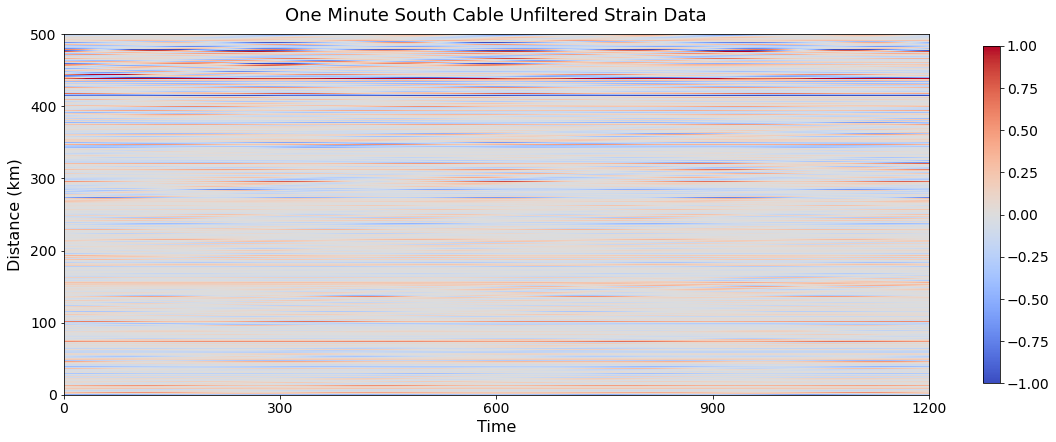

In [26]:
kdv = (-6*working_dat[:12000,:,0].T*ux[:12000,:,0].T)-uxxx[:12000,:,0].T
fig, ax = plt.subplots(figsize = (16, 6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((kdv[::10,::10]),vmin=-1, vmax=1,
               extent = [0,1200,  0,500],
               cmap = 'coolwarm')

ax.set_xlabel("Time",size=16)
ax.set_ylabel("Distance (km)",size=16, labelpad = 8)#, fontsize = 16)


jump_val = 500

ax.set_xticks(np.linspace(0,1200, 5))#,np.linspace(0,12000, 5)/10000)
# ax.xaxis_date()
# date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')
# ax.xaxis.set_major_formatter(date_format)
# ax.set_xticklabels([x.strftime('%d-%b\n%H:%M:%S.%f') for x in mdates.num2date(np.linspace(toas[0], toas[1], 5))])
# plt.xticks(rotation=15)

# plt.yticks(np.arange(y_lims[0], y_lims[1]+jump_val, jump_val),
#            np.round((2/1000)*np.arange(y_lims[0], y_lims[1]+jump_val, jump_val)))

ax.set_title("One Minute South Cable Unfiltered Strain Data",fontsize=18,y=1.02)#file.split('.')[0])
plt.colorbar(im, ax = ax, pad = 0.05,shrink=0.9)
plt.show()

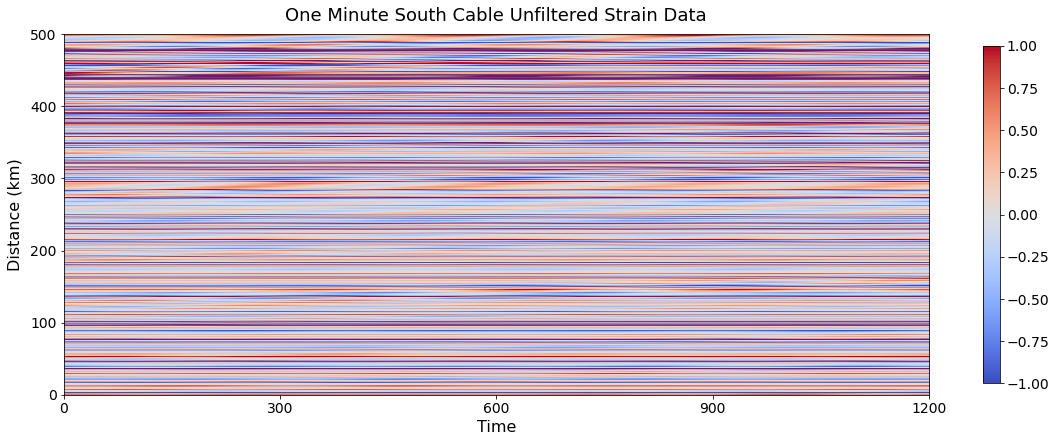

In [27]:
# output = ((15.534*ux[:12000:10,::10,0])  +(19.324*uxxx[:12000:10,::10,0]) + (3.325* working_dat[:12000:10,::10,0]*uxx[:12000:10,::10,0])).T
output=((16.183* ux[:12000:10,::10,0]) +( 19.616* uxxx[:12000:10,::10,0])).T
fig, ax = plt.subplots(figsize = (16, 6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((output),vmin=-1, vmax=1,
               extent = [0,1200,  0,500],
               cmap = 'coolwarm')

ax.set_xlabel("Time",size=16)
ax.set_ylabel("Distance (km)",size=16, labelpad = 8)#, fontsize = 16)


jump_val = 500

ax.set_xticks(np.linspace(0,1200, 5))#,np.linspace(0,12000, 5)/10000)
# ax.xaxis_date()
# date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')
# ax.xaxis.set_major_formatter(date_format)
# ax.set_xticklabels([x.strftime('%d-%b\n%H:%M:%S.%f') for x in mdates.num2date(np.linspace(toas[0], toas[1], 5))])
# plt.xticks(rotation=15)

# plt.yticks(np.arange(y_lims[0], y_lims[1]+jump_val, jump_val),
#            np.round((2/1000)*np.arange(y_lims[0], y_lims[1]+jump_val, jump_val)))

ax.set_title("One Minute South Cable Unfiltered Strain Data",fontsize=18,y=1.02)#file.split('.')[0])
plt.colorbar(im, ax = ax, pad = 0.05,shrink=0.9)
plt.show()

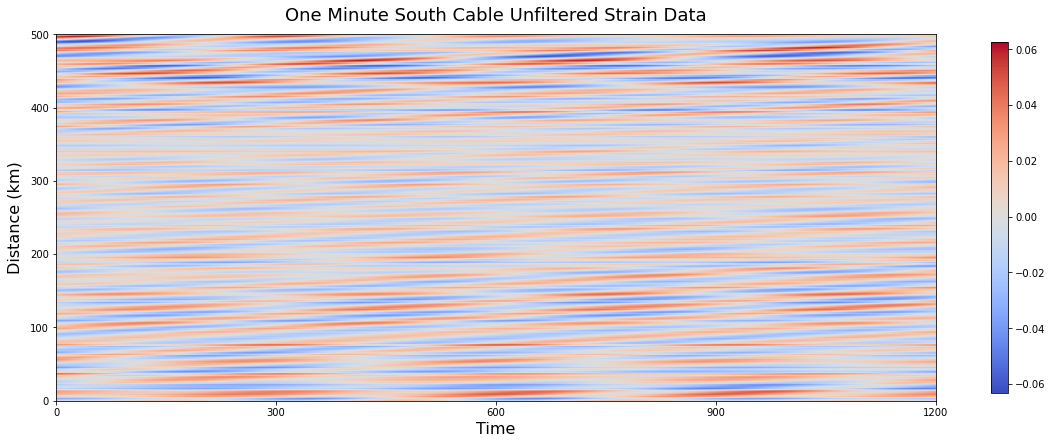

In [10]:
# output = ((-15.534*ux[:12000:10,::10,0])  -(19.324*uxxx[:12000:10,::10,0]) - (3.325* working_dat[:12000:10,::10,0]*uxx[:12000:10,::10,0])).T
output=np.load('test_deriv.npy')[::10,::10,0].T
fig, ax = plt.subplots(figsize = (16, 6))
fig.patch.set_facecolor('white') # Good for dark themed notebooks
plt.tight_layout()
im = ax.imshow((ux[:12000:10,::10,0].T),#vmin=-1, vmax=1,
               extent = [0,1200,  0,500],
               cmap = 'coolwarm')

ax.set_xlabel("Time",size=16)
ax.set_ylabel("Distance (km)",size=16, labelpad = 8)#, fontsize = 16)


jump_val = 500

ax.set_xticks(np.linspace(0,1200, 5))#,np.linspace(0,12000, 5)/10000)
# ax.xaxis_date()
# date_format = mdates.DateFormatter('%d-%b\n%H:%M:%S.%f')
# ax.xaxis.set_major_formatter(date_format)
# ax.set_xticklabels([x.strftime('%d-%b\n%H:%M:%S.%f') for x in mdates.num2date(np.linspace(toas[0], toas[1], 5))])
# plt.xticks(rotation=15)

# plt.yticks(np.arange(y_lims[0], y_lims[1]+jump_val, jump_val),
#            np.round((2/1000)*np.arange(y_lims[0], y_lims[1]+jump_val, jump_val)))

ax.set_title("One Minute South Cable Unfiltered Strain Data",fontsize=18,y=1.02)#file.split('.')[0])
plt.colorbar(im, ax = ax, pad = 0.05,shrink=0.9)
plt.show()

## Simulate

In [4]:
from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph, PDEBase
import matplotlib
matplotlib.rcParams.update({'font.size': 15})

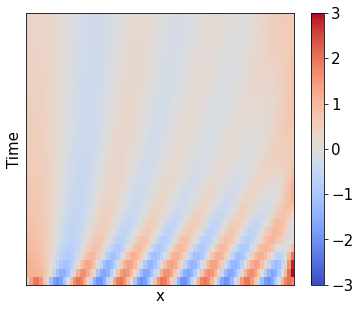

In [29]:
# Expanded definition of the PDE
# diffusivity = "1.01 + tanh(x)"
# term_1 = f"({diffusivity}) * laplace(c)"
# term_2 = f"dot(gradient({diffusivity}), gradient(c))"
# eq = PDE({"c": f"{term_1} + {term_2}"}, bc={"value": 0})
class WavePDE(PDEBase):
    """Korteweg-de Vries equation"""

    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        assert state.grid.dim == 1  # ensure the state is one-dimensional
        grad_x = state.gradient("auto_periodic_neumann")[0]
        return  0.067*grad_x -0.003 *(1)* state.laplace("auto_periodic_neumann").laplace("auto_periodic_neumann")  +0.048 *grad_x.laplace("auto_periodic_neumann")
#  x0_1 + 0.048 x0_111 + -0.003 x0_1111 +  x0x0_1111


grid = CartesianGrid([[0, 10.]], 80)  # generate grid
# field = ScalarField(grid, 1)  # generate initial condition
state = ScalarField.from_expression(grid, "2 *sin(4*x)")

eq = WavePDE()
storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(state, 8, dt=1e-4, tracker=storage.tracker(0.1))  # solve the PDE
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
ax.set_xticks([])
ax.set_yticks([])
img = plot_kymograph(storage,cmap="coolwarm",ax=ax,vmax=3, vmin=-3)
plt.show()

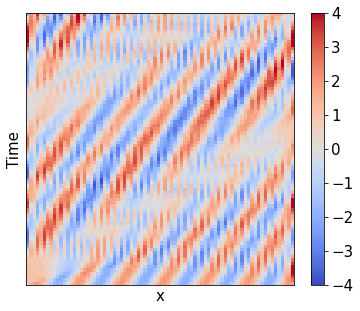

In [28]:
# from pde import PDE, CartesianGrid, MemoryStorage, ScalarField, plot_kymograph, PDEBase

# Expanded definition of the PDE
# diffusivity = "1.01 + tanh(x)"
# term_1 = f"({diffusivity}) * laplace(c)"
# term_2 = f"dot(gradient({diffusivity}), gradient(c))"
# eq = PDE({"c": f"{term_1} + {term_2}"}, bc={"value": 0})
class WavePDE(PDEBase):
    """Korteweg-de Vries equation"""

    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        assert state.grid.dim == 1  # ensure the state is one-dimensional
        grad_x = state.gradient("auto_periodic_neumann")[0]
        return  0.067*grad_x  +0.058 *grad_x.laplace("auto_periodic_neumann")
#  x0_1 + 0.048 x0_111 + -0.003 x0_1111 +  x0x0_111

grid = CartesianGrid([[0, 10.]], 80)  # generate grid
# field = ScalarField(grid, 1)  # generate initial condition
state = ScalarField.from_expression(grid, "2 *sin(4*x)")


# eq = PDE({"u": "-gradient_squared(u) / 2 - laplace(u + laplace(u))"})  # define the pde
# result = eq.solve(state, t_range=10, dt=0.01)
eq = WavePDE()
storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(state, 8, dt=1e-4, tracker=storage.tracker(0.1))  # solve the PDE
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
ax.set_xticks([])
ax.set_yticks([])
img = plot_kymograph(storage,cmap="coolwarm",ax=ax,vmax=4, vmin=-4)
plt.show()

/home/ldoyle/packages/pde/fields/base.py:511: RuntimeWarning: overflow encountered in power
  op(self.data, other, out=result.data)
/home/ldoyle/packages/pde/fields/base.py:505: RuntimeWarning: overflow encountered in multiply
  op(self.data, other.data, out=result.data)
/home/ldoyle/packages/pde/fields/base.py:505: RuntimeWarning: invalid value encountered in subtract
  op(self.data, other.data, out=result.data)
/home/ldoyle/packages/pde/fields/base.py:505: RuntimeWarning: invalid value encountered in add
  op(self.data, other.data, out=result.data)


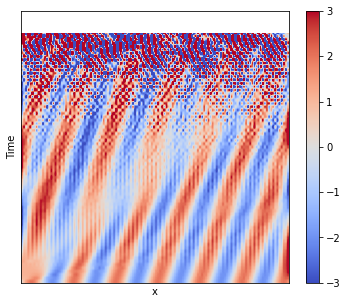

In [7]:
# Expanded definition of the PDE

class WavePDE(PDEBase):
    """Korteweg-de Vries equation"""

    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        assert state.grid.dim == 1  # ensure the state is one-dimensional
        grad_x = state.gradient("auto_periodic_neumann")[0]
        return  0.067*grad_x -0.009 *grad_x*(state)**2 +0.03 *grad_x.laplace("auto_periodic_neumann")
#  x0_1 + 0.048 x0_111 + -0.003 x0_1111 +  x0x0_1111


grid = CartesianGrid([[0, 10.]], 128)  # generate grid
# field = ScalarField(grid, 1)  # generate initial condition
state = ScalarField.from_expression(grid, "2 *sin(4*x)")

eq = WavePDE()
storage = MemoryStorage()  # store intermediate information of the simulation
res = eq.solve(state, 8, dt=1e-4, tracker=storage.tracker(0.1))  # solve the PDE
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(6,5))
ax.set_xticks([])
ax.set_yticks([])
img = plot_kymograph(storage,cmap="coolwarm",ax=ax,vmax=3, vmin=-3)
plt.show()